In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading and cleaning data

In [7]:
file_name = 'rossmann_train.csv'
df = pd.read_csv(file_name)

C:\Users\jiexun.see\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df=df.iloc[::-1] # reverses order of rows so that it is from oldest to newest

In [144]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1


In [145]:
d = df.drop(df[df['Store'] > 1].index)

In [146]:
d.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1


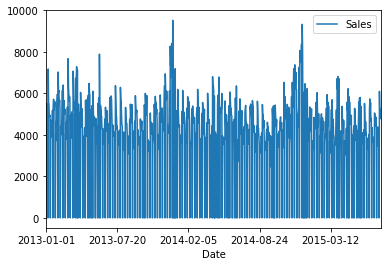

In [147]:
d.plot(x='Date', y='Sales')

In [150]:
# change state holiday status to 1 or 0
d.loc[d.StateHoliday == 'a', 'StateHoliday'] = 1
d.loc[d.StateHoliday == 'b', 'StateHoliday'] = 1
d.loc[d.StateHoliday == 'c', 'StateHoliday'] = 1

d['StateHoliday'] = d['StateHoliday'].astype(int)
d.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,942.0,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,1.0,3.997877,3945.704883,467.646497,0.829087,0.382166,0.028662,0.204883
std,0.0,1.998404,2015.417840,228.930850,0.376633,0.486175,0.166945,0.403831
min,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,2.000000,3588.250000,463.000000,1.000000,0.000000,0.000000,0.000000
50%,1.0,4.000000,4373.500000,529.000000,1.000000,0.000000,0.000000,0.000000
75%,1.0,6.000000,5220.000000,598.750000,1.000000,1.000000,0.000000,0.000000
max,1.0,7.000000,9528.000000,1130.000000,1.000000,1.000000,1.000000,1.000000


# Approach 1: (Partially) Autoregressive LSTM
X1 data: 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday' for previous days

X2 data: 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday' for the day

---
Y target: 'Sales' for the day

### Scaling and packaging the data

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
def get_batches(xdata, ydata, n_prev):
    X = []
    Y = []
    n = len(xdata)

    for i in np.arange(n)[n_prev:-1]:
        x = xdata[i-n_prev:i+1]
        X.append(x)
        Y.append(ydata[i+1])
    
    return np.array(X), np.array(Y)

In [177]:
def get_batches_and_same_day(xdata, ydata, n_prev):
    X1 = []
    X2 = []
    Y = []
    n = len(xdata)

    for i in np.arange(n)[n_prev:]:
        x = xdata[i-n_prev:i]
        X1.append(x)
        Y.append(ydata[i])
        X2.append(xdata[i,1:])
    
    return np.array(X1), np.array(X2), np.array(Y)

In [185]:
def split_train_test(data, test_frac):
    if isinstance(data, list):
        out_train = []
        out_test = []
        n = data[0].shape[0]
        split = round(n*(1-test_frac))
        for d in data:
            out_train.append(d[0:split])
            out_test.append(d[split:n])
        return tuple(out_train), tuple(out_test)   
    else:
        n = data.shape[0]
        split = round(n*(1-test_frac))
        return data[0:split], data[split:n]    

In [17]:
xdata = np.array(a[['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']])
ydata = np.array(a['Sales']).reshape(-1,1)

x_scaler = MinMaxScaler()
norm_X = x_scaler.fit_transform(xdata)

y_scaler = MinMaxScaler()
norm_Y = y_scaler.fit_transform(ydata)

C:\Users\jiexun.see\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [178]:
n_prev = 10
# X, Y = get_batches(norm_X, norm_X, n_prev) # use norm_X, norm_X, n_prev for an autoregressive model
X1, X2, Y = get_batches_and_same_day(norm_X, norm_X, n_prev)
assert (X2.shape[0] == X1.shape[0] == Y.shape[0])

(932, 10, 6)
(932, 6)


In [192]:
# Split the data into training and test set. (chop off last portion of training set and use as test set)
(X1_train, X2_train, Y_train), (X1_test, X2_test, Y_test) = split_train_test([X1, X2, Y], 0.2)
print (X2_test.shape)
print (X2_train.shape)

(186, 5)
(746, 5)


### Stateful LSTM for to predict future sales

Using a stateful LSTM, with sequence length of (n_prev+1)

helpful link: http://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

In [84]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout, Masking, Reshape, Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers.recurrent import LSTM
from keras.layers.merge import Concatenate
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam

In [195]:
hidden = 32
dropout = 0.4
epochs = 10
batch_size = 1

In [193]:
'''
# Build sequential model. (This model doesn't use data from the same day)
model = Sequential()
model.add(Masking([0,0,0,0,0,0], batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
model.add(LSTM(hidden, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dropout(0.3))
model.add(Concatenate())
model.add(Dense(6))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
'''


############# NEW MODEL THAT USES SAME DAY INFO ############## (Requires model functional API instead of sequential model)
input1 = Input(batch_shape=(batch_size,X1_train.shape[1],X1_train.shape[2]))
input2 = Input(batch_shape=(batch_size,X2_train.shape[1]))

a = LSTM(hidden, stateful=True)(input1)
a = Dropout(dropout)(a)

merged = Concatenate()([a, input2])
out = Dense(X1_train.shape[2])(merged)

model = Model(inputs=[input1, input2], outputs=out)
model.compile(loss='mse', optimizer='rmsprop')

In [196]:
print ('Fitting model ...')
print (X1_train.shape)
print (X2_train.shape)
print (Y_train.shape)
for i in range(epochs):
    model.fit(x=[X1, X2], y=Y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states() # stateful model doesn't reset states after every input

Fitting model ...
(746, 10, 6)
(746, 5)
(746, 6)
Epoch 1/1
932/932 [==============================] - 384s - loss: 0.0694   
Epoch 1/1
932/932 [==============================] - 366s - loss: 0.0210   
Epoch 1/1
932/932 [==============================] - 368s - loss: 0.0142   
Epoch 1/1
932/932 [==============================] - 368s - loss: 0.0105   
Epoch 1/1
932/932 [==============================] - 367s - loss: 0.0084   
Epoch 1/1
932/932 [==============================] - 369s - loss: 0.0068   
Epoch 1/1
932/932 [==============================] - 383s - loss: 0.0059   
Epoch 1/1
932/932 [==============================] - 376s - loss: 0.0047   
Epoch 1/1
932/932 [==============================] - 372s - loss: 0.0038   
Epoch 1/1
932/932 [==============================] - 371s - loss: 0.0030   


In [197]:
# Making a prediction. Just to see it works.
pred = x_scaler.inverse_transform(model.predict([np.expand_dims(X1[0], 0), X2[0].reshape(1,5)])) # change accordingly
print ('Predicted: {}, Actual: {}'.format(pred, x_scaler.inverse_transform([Y[0]])))

Predicted: [[  5.01215186e+03   5.72885193e+02   1.02288961e+00   9.93158638e-01
   -4.16163169e-03   9.61499095e-01]], Actual: [[  4.88100000e+03   5.92000000e+02   1.00000000e+00   1.00000000e+00
    0.00000000e+00   1.00000000e+00]]


### Making autoregressive forecasts

In [286]:
# Getting a seed to kickstart autoregressive predictions. Predicting on test set data.
x = X1_test[0]
prediction = np.squeeze(x)
x = np.expand_dims(x, axis=0)
print (prediction.shape)

(10, 6)


In [287]:
for i in range(len(X2_test)):
    preds = model.predict([x, X2_test[i].reshape(1, -1)])
    x = np.squeeze(x)
    x = np.concatenate((x, preds))
    x = x[1:]
    x = np.expand_dims(x, axis=0)
    prediction = np.concatenate((prediction, preds))
print (prediction.shape)

(196, 6)


In [288]:
pred = x_scaler.inverse_transform(prediction)
Y_test_unnorm = x_scaler.inverse_transform(Y_test)

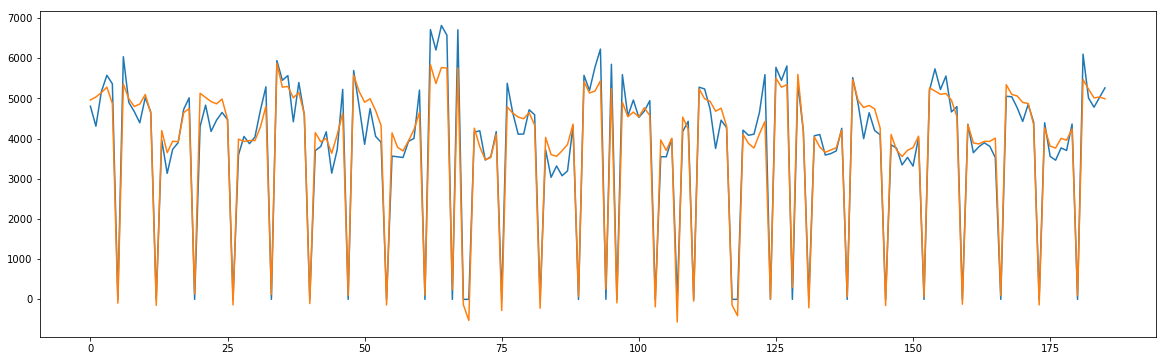

In [289]:
n = len(Y_test_unnorm)

fig = plt.figure(figsize=(20,6))
plt.plot(range(n), Y_test_unnorm[:,0])
plt.plot(range(n), pred[-n:,0])

In [290]:
diff = abs(Y_test_unnorm[:,0] - pred[-n:, 0])
percentage_diff = diff/(pred[-n:, 0]+1e-10)
indices = [i for i in range(n) if (percentage_diff[i]<0.10)]
print ('Percentage of predictions that are within 10% from true value: {:.2f}%'.format(len(indices)/len(pred[-n:,0])*100))

Percentage of predictions that are within 10% from true value: 72.58%


In [291]:
def calculate_RMSE(y1, y2):
    return np.sqrt(np.mean(np.square(y1-y2)))

In [292]:
# Calculate RMSE error
RMSE = calculate_RMSE(Y_test_unnorm[:,0], pred[-n:,0])
print ('RMSE error on test set (using true values to predict): {}'.format(RMSE))

RMSE error on test set (using true values to predict): 370.01971168608276


### Making forecasts at each time step given true data, hence surfacing anomalies

In [293]:
# Getting a seed. Predicting on test set data.
x = X1_test[0]
prediction = np.squeeze(x)
x = np.expand_dims(x, axis=0)

In [294]:
for i in range(len(X2_test)):
    preds = model.predict([x, X2_test[i].reshape(1,-1)])
    x = np.squeeze(x)
    y_true = [Y_test[i]]
    x = np.concatenate((x, y_true))
    x = x[1:]
    x = np.expand_dims(x, axis=0)
    prediction = np.concatenate((prediction, preds)) 

In [295]:
pred = x_scaler.inverse_transform(prediction)
Y_test_unnorm = x_scaler.inverse_transform(Y_test)

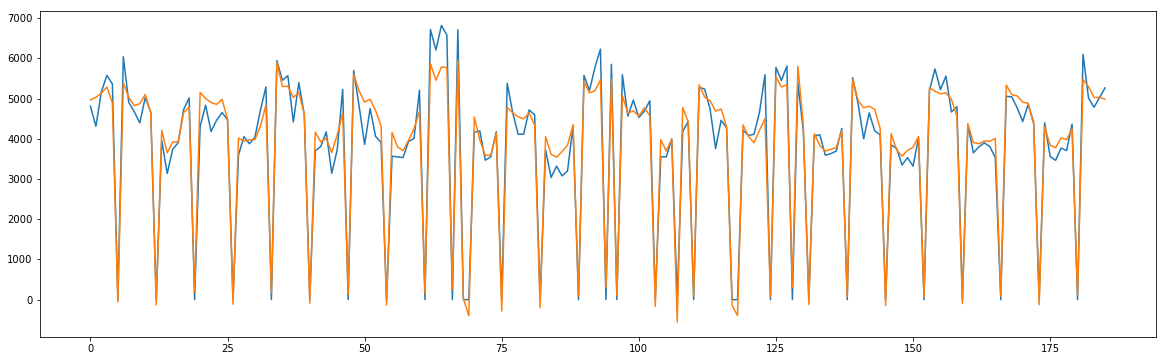

In [296]:
n = len(Y_test_unnorm)

plt.figure(figsize=(20,6))
plt.plot(range(n), Y_test_unnorm[:,0])
plt.plot(range(n), pred[-n:,0])

In [297]:
diff = abs(Y_test_unnorm[:,0] - pred[-n:, 0])
percentage_diff = diff/(pred[-n:, 0]+1e-10)
indices = [i for i in range(n) if (percentage_diff[i]<0.10)]
print ('Percentage of predictions that are within 10% from true value (using true values to predict): {:.2f}%'.format(len(indices)/len(pred[-n:,0])*100))

Percentage of predictions that are within 10% from true value (using true values to predict): 71.51%


In [298]:
# Calculate RMSE error
RMSE = calculate_RMSE(Y_test_unnorm[:,0], pred[-n:,0])
print ('RMSE error on test set (using true values to predict): {}'.format(RMSE))

RMSE error on test set (using true values to predict): 360.95936720267605


# Approach 2a: Non- Autoregressive LSTM
X data: 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'

Y target: 'Sales' for the same day

** Note: not autoregressive

### Scaling and packaging the data

In [300]:
xdata = np.array(d[['Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']])
ydata = np.array(d['Sales']).reshape(-1,1)

x_scaler = MinMaxScaler()
norm_X = x_scaler.fit_transform(xdata)

y_scaler = MinMaxScaler()
norm_Y = y_scaler.fit_transform(ydata)

C:\Users\jiexun.see\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [301]:
X = np.reshape(norm_X, (len(norm_X), 1, -1)) # sequence length of 1
Y = np.reshape(norm_Y, (len(norm_Y), -1))

In [302]:
hidden = 10
dropout = 0.4
epochs = 10
batch_size = 1

In [303]:
model = Sequential()
model.add(LSTM(hidden, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [304]:
print ('Fitting model ...')
for i in range(epochs):
    model.fit(X, Y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states() # stateful model doesn't reset states after every input

Fitting model ...
Epoch 1/1
942/942 [==============================] - 56s - loss: 0.0458    
Epoch 1/1
942/942 [==============================] - 57s - loss: 0.0182    
Epoch 1/1
942/942 [==============================] - 61s - loss: 0.0118    
Epoch 1/1
942/942 [==============================] - 55s - loss: 0.0096    
Epoch 1/1
942/942 [==============================] - 52s - loss: 0.0080    
Epoch 1/1
942/942 [==============================] - 60s - loss: 0.0064    
Epoch 1/1
942/942 [==============================] - 53s - loss: 0.0065    
Epoch 1/1
942/942 [==============================] - 56s - loss: 0.0058    
Epoch 1/1
942/942 [==============================] - 56s - loss: 0.0050    
Epoch 1/1
942/942 [==============================] - 54s - loss: 0.0049    


In [238]:
pred = y_scaler.inverse_transform(model.predict(np.expand_dims(X[0], 0)))
print ('Predicted: {}, Actual: {}'.format(pred, y_scaler.inverse_transform([Y[0]])))

Predicted: [[ 1169.53283691]], Actual: [[ 0.]]


# Approach 2b: Simple FF NN

In [267]:
X = X.reshape(X.shape[0], -1)

In [288]:
epochs = 200
hidden = 50
input_dim = X.shape[1]

In [289]:
ff = Sequential()
ff.add(Dense(hidden, input_dim=input_dim))
ff.add(Activation('relu'))
ff.add(Dropout(0.4))
ff.add(Dense(1))
ff.add(Activation('linear'))
ff.compile(loss='mean_squared_error', optimizer='adam')

In [290]:
print ('Fitting model ...')
ff.fit(X, Y, epochs=epochs, verbose=0, shuffle=False)
print ('Done training')

Fitting model ...
Done training


In [291]:
pred = y_scaler.inverse_transform(ff.predict(X[0].reshape(1,5)))
print ('Predicted: {}, Actual: {}'.format(pred, y_scaler.inverse_transform([Y[0]])))

Predicted: [[ 63.40891266]], Actual: [[ 0.]]


# Approach 3: Vector Autoregression

In [1]:
from statsmodels.tsa.api import VAR, DynamicVAR

C:\Users\jiexun.see\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
xdata = np.array(d[['Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']])

In [28]:
model = VAR(xdata)

In [29]:
results = model.fit()

In [30]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Aug, 2017
Time:                     12:02:40
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    7.61021
Nobs:                     941.000    HQIC:                   7.47633
Log likelihood:          -11448.1    FPE:                    1625.99
AIC:                      7.39387    Det(Omega_mle):         1555.27
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const      4951.365493       146.518860           33.793           0.000
L1.y1        -0.423800         0.209176           -2.026           0.043
L1.y2         2.694300         2.074317            1.299           0.194
L1.y3     -1800.194586

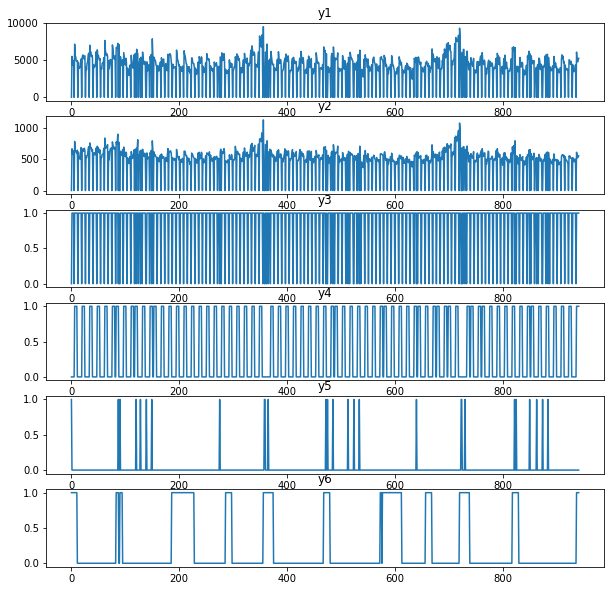

In [31]:
results.plot()

In [33]:
lag_order = results.k_ar
print (lag_order)

1


In [38]:
results.forecast(xdata[-lag_order:], 150)

array([[  4.81494053e+03,   5.40917096e+02,   9.64357626e-01,
          8.43742646e-01,   6.20470031e-02,   9.31577451e-01],
       [  4.61235951e+03,   5.33084060e+02,   9.47715613e-01,
          6.66647823e-01,   5.44777886e-02,   8.60618542e-01],
       [  4.28347777e+03,   5.02330986e+02,   8.98796386e-01,
          5.31771161e-01,   4.99704131e-02,   7.97203446e-01],
       [  4.10495839e+03,   4.85020878e+02,   8.72192579e-01,
          4.51001440e-01,   4.78300830e-02,   7.43509499e-01],
       [  3.98856470e+03,   4.73219719e+02,   8.53800961e-01,
          4.02047363e-01,   4.61709178e-02,   6.96823537e-01],
       [  3.92277957e+03,   4.66423869e+02,   8.42849747e-01,
          3.74102205e-01,   4.47722949e-02,   6.55716628e-01],
       [  3.88640747e+03,   4.62595318e+02,   8.36240297e-01,
          3.58796546e-01,   4.34885449e-02,   6.18989183e-01],
       [  3.86828457e+03,   4.60641833e+02,   8.32397430e-01,
          3.51107315e-01,   4.22957648e-02,   5.85838017e-01],


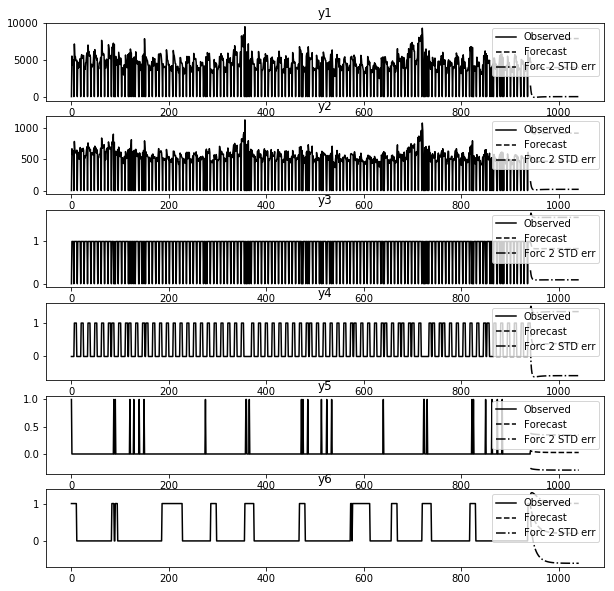

In [40]:
results.plot_forecast(100)

# Approach 4: SARIMAX (only for univariate)

In [43]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

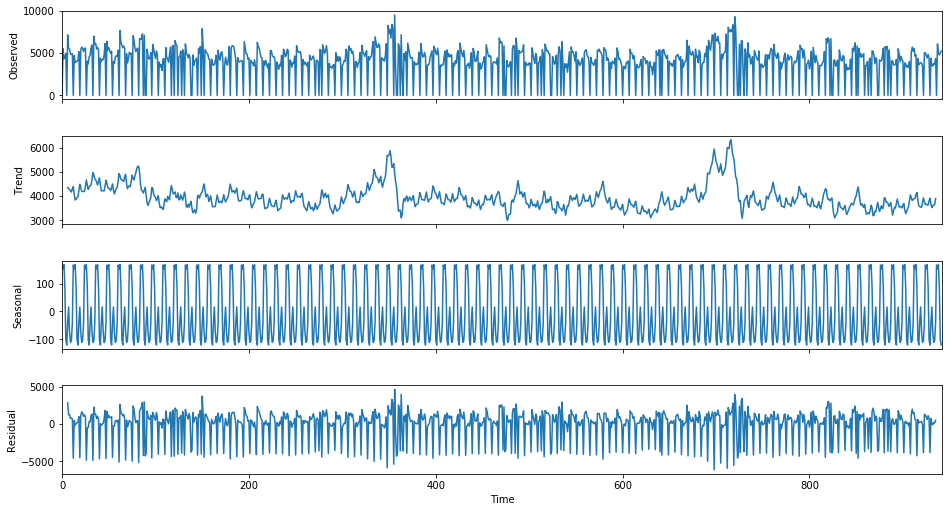

In [54]:
decomposition = seasonal_decompose(np.array(a['Sales']), freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [65]:
mod = SARIMAX(np.array(d ['Sales']), trend='n', order=(0,1,0), seasonal_order=(0,1,1,7))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  942
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -8136.903
Date:                           Mon, 07 Aug 2017   AIC                          16277.806
Time:                                   12:28:03   BIC                          16287.502
Sample:                                        0   HQIC                         16281.502
                                           - 942                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.9999      0.020    -49.757      0.000      -1.039      -0.961
sigma2       2.11e+06   9.57e-09    2.2e+14

In [67]:
mod = SARIMAX(np.array(a['Sales']), trend='n', order=(0,1,0), seasonal_order=(1,1,1,7))
results = mod.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  942
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 7)   Log Likelihood               -8136.874
Date:                           Mon, 07 Aug 2017   AIC                          16279.749
Time:                                   12:28:35   BIC                          16294.293
Sample:                                        0   HQIC                         16285.292
                                           - 942                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.0049      0.033      0.148      0.883      -0.060       0.069
ma.S.L7       -1.0000      0.020    -50.347

In [68]:
len(a)

942

In [106]:
forecast = results.predict(start = 900, end= 960, dynamic= False) 

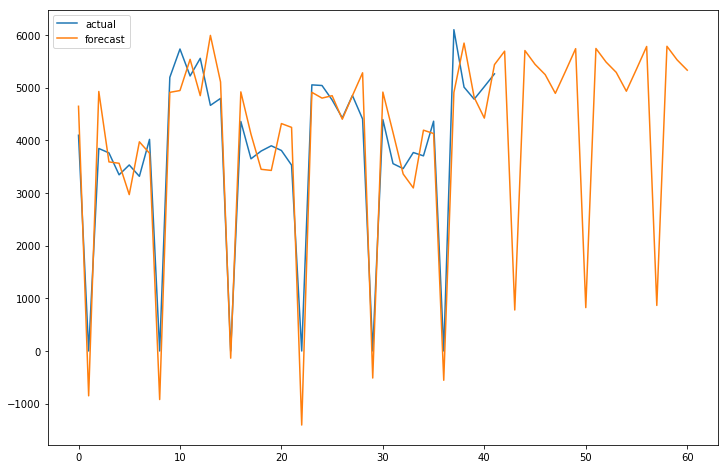

In [107]:
fig.clear()
plt.figure(figsize=(12,8))
actual = plt.plot(np.array(a['Sales'])[900:], label='actual')
fc = plt.plot(forecast, label='forecast')
plt.legend(handles=[actual[0], fc[0]])